In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns',500)
# used for sorting
from operator import itemgetter

# RetroSheet Data
All the data used in this project is from https://www.retrosheet.org/. This organization collects all baseball events and statistics since they started recording this information.

## Year-spanning stats


In [53]:
# these are the columns of the data frame
# these are year-spanning stats
from dataframe_creation import get_pbp_columns
columns = get_pbp_columns()

In [57]:
# all years that the data is from
year_list = list(range(2000,2020,1))

In [55]:
# importing the data from each file
# the files are done year by year
df = pd.DataFrame()
for year_list in years:
    url = 'data/retro_data/year_games/GL{}.txt'.format(year)
    temp = pd.read_csv(url)
    temp.columns = columns
    df = df.append(temp)

Some teams in the past 20 years have swtiched their name so the tag changed. Here are those changes:
* Florida Marlins (FLO) -> Miami Marlins (MIA)
* Montreal Expos (MON) -> Washinton Nationals (WAS)

In [28]:
# changing those team names
df = df.applymap(lambda x: "WAS" if x=='MON'else ('MIA' if x=='FLO' else x))

In [29]:
# there are some columns that contain mostly nan's and will be dropped
pd.set_option('display.max_rows', 1000)
print(df.isna().sum())
pd.set_option('display.max_rows', 50)

Date                            0
game_in_series                  0
day_of_week                     0
away_team                       0
away_league                     0
away_team_game_number           0
home_team                       0
home_league                     0
home_team_game_number           0
away_team_score                 0
home_team_score                 0
number_of_outs                  0
day_or_night                    0
date_game_completed         48536
forfeit_info                48568
protest_info                48543
park_id                         0
attendance                      1
time_of_game                    0
away_line_scores                0
home_line_scores                0
away_at_bats                    0
away_hits                       0
away_doubles                    0
away_triples                    0
away_hrs                        0
away_rbi                        0
away_sh                         0
away_sf                         0
away_hbp      

In [30]:
# some games have been cancelled in the past 20 years
# there is no need to be concerned as we are predicting on a game by game basis
# one game will not throw off the cumulative statistics
most_games_played_past_20 = df.groupby('away_team').count().Date.max()
least_games_played_past_20 = df.groupby('away_team').count().Date.min()
print('Most games played in past 20 years:',most_games_played_past_20)
print('Least games played in past 20 years:',least_games_played_past_20)

Most games played in past 20 years: 1622
Least games played in past 20 years: 1616


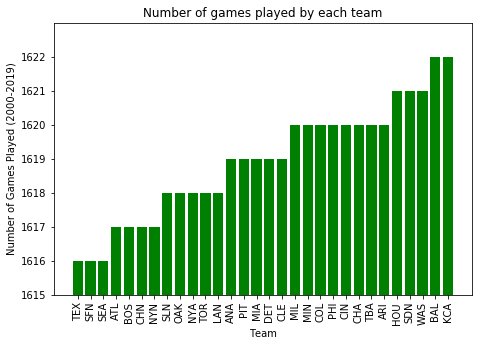

In [35]:
# showing all the games played by each team
num_games_played_df = df.groupby('away_team').count().Date.copy()
num_games_played_df.sort_values(inplace=True)
x = num_games_played_df.index
y = list(num_games_played_df)
fig, ax = plt.subplots(figsize=(7.5,5))
ax.bar(x,y,color='green')
ax.set_ylim(bottom = 1615,top = 1623)
ax.set_yticks(ticks=range(1615,1623,1))
ax.set_xticklabels(labels=x,rotation=90)
ax.set_title('Number of games played by each team')
ax.set_xlabel('Team')
ax.set_ylabel('Number of Games Played (2000-2019)');

# Feautre Enginnering

# Creating Player game-by-game statistics
These are definitons of all statistics that are recorded or can be calculated.

G: Games. Tells how many games the player actually took the field in or appeared at the plate. IMPORTANT NOTE: If the data in the G column is a dark maroon link, click it and up will appear comprehensive hitting logs that show every game the player appeared in and links to those boxscores.

AB: At-bats. Count of times in the batters box, but excludes walks, sacrifices, catcher interference, or being hit by the pitcher.

R: Runs Scored. The number of times the batter scored a run.

H: Hits. A safely hit ball that that allowed him to reach base safely.

2B: Doubles. A hit (H) that allowed the batter to reach second base safely.

3B: Triples. A hit (H) that allowed the batter to reach third base safely.

HR: Home Runs. A hit (H) that allowed the batter to circle all the bases safely.

GRSL: Grand Slams. A hit (H) that allowed the batter to circle all the bases (which were loaded with baserunners) safely.

RBI: Runs Batted In. Earned by a batter when a runner scores due to a base hit, a sacrifice, being hit by a pitch, during an infield out (but not during a double play), or a fielder's choice.

BB: Base on Balls. Stat awarded when a batter is awarded first base by the umpire for pitches called a ball by the umpire.

IBB: Intentional Base on Balls. Counts the number of times a walk was issued with no intent of ever allowing a hit.

SO: Strikeouts. Number of times called out on strikes by the umpire.

SH: Sacrifice Hits. A ball hit that advanced the baserunner at the cost of being put out.

SF: Sacrifice Fly. A sacrifice hit (SH) done with less than two outs, fair or foul, that allows one or more baserunners to tag up and score.

HBP: Hit by Pitch(er). Total number of being struck by the pitcher whether or not it was intentional.

GIDP: Ground Into Double Play. The number of times a ball hit by the batter started a double play (two outs).

AVG: Batting Average. The player's total number of hits (H) divided by their total number of at-bats (AB).

OBP: On Base Percentage. Determines what percentage of a player's plate appearances resulted in him reaching base safely. Calculated by adding hits (H) & base on balls (BB) & hit by pitch (HBP) then dividing that by the player's at-bats (AB) & base on balls (BB) & sacrifice fly (SF) and hit by pitch (HBP).

SLG: Slugging Percentage. An offensive ability type stat calculated by taking the total bases `singles + 2 x doubles (2B) + 3 x triples (3B) + 4 x home runs (HR)` reached then dividing it by the number of at-bats (AB).

BABIP: Batting Average on Balls in Play. `(H - HR)/(AB - K - HR + SF)`

ISO: Isolated Power. `(1x2B + 2x3B + 3xHR) / At-bats OR Slugging percentage - Batting average`

LIPS: Late-inning preassure situation. Late-inning pressure situations are defined as `any at-bat in the seventh inning or later where the batter's team trails by three runs or fewer, is tied or is ahead by only one run. If the bases are loaded and the batting team trails by four runs, this also counts as a late-inning pressure situation`.

OPS+: On-base Plus Slugging Plus. `(OPS / league OPS, adjusted for park factors) x 100.` player's on-base plus slugging percentage and normalizes the number across the entire league

PA/SO: Plate appearances per strikeout is a basic ratio determined by dividing a player's total plate appearances by his number of strikeouts. Hitters who don't strike out very much will have high PA/SO marks.

P/PA: pitches per plate appearance. How many pitches are thrown per plate appearance

RC: runs created. `TB x (H + BB) / (AB + BB)`

wRAA: weighted runs above average `((wOBA - wOBA of the entire league) / annual wOBA scale) x PA`

wOBA: Weighted On-base Average. `0.69 x uBB + 0.72 x HBP + 0.89. x 1B + 1.27 x 2B + 1.62 x 3B + 2.10 x HR / AB + BB - IBB + SF + HBP



In [62]:
# converting to date time
df.Date = pd.to_datetime(df.Date,format='%Y%m%d')

In [63]:
# creating a game id that can be used for indetification of each game
df['id'] = df['home_team']+df.Date.dt.year.astype('str') + df.Date.dt.month.astype('str') + df.Date.dt.day.astype('str')

In [64]:
# creating year column for grouping
df['year'] = df.Date.map(lambda x: x.year)

In [65]:
# outcome of game in terms of home team  loosing (0) or winning (1)
# have to change score to int
df.home_team_score.astype('int')
df.away_team_score.astype('int')
cond = [
    df.home_team_score > df.away_team_score,
    df.away_team_score > df.home_team_score
]
outcome = [
    1, # home wins
    0  # away wins
]
df['home_outcome'] = np.select(cond,outcome,default = -1)

In [66]:
# outcome of game in terms of away team  loosing (0) or winning (1)
cond = [
    df.away_team_score > df.home_team_score, # away wins
    df.home_team_score > df.away_team_score  # home wins
]
outcome = [
    1, # away wins
    0  # home wins
]
df['away_outcome'] = np.select(cond,outcome,default = -1)

In [67]:
# OBP = (Hits + Walks + Hit by Pitch) / (At Bats + Walks + Hit by Pitch + Sacrifice Flies)
df['home_OBP'] = (df.home_hits + df.home_walk + df.home_hbp) / (df.home_at_bats + df.home_walk + df.home_hbp + df.home_sf)
df['away_OBP'] = (df.away_hits + df.away_walk + df.away_hbp) / (df.away_at_bats + df.away_walk + df.away_hbp + df.away_sf)

In [68]:
# AVG = hits / at bats
df['home_AVG'] = df.home_hits / df.home_at_bats
df['away_AVG'] = df.away_hits / df.away_at_bats

In [69]:
# singles = hits - (doubles + triples + hr)
df['home_singles'] = df.home_hits - (df.home_doubles + df.home_triples + df.home_hrs)
df['away_singles'] = df.away_hits - (df.away_doubles + df.away_triples + df.away_hrs)

In [70]:
# SLG = singles + 2 x doubles (2B) + 3 x triples (3B) + 4 x home runs (HR) / AB
df['home_SLG'] = (df.home_singles + 2*df.home_doubles + 3*df.home_triples + 4*df.home_hrs) / df.home_at_bats
df['away_SLG'] = (df.away_singles + 2*df.away_doubles + 3*df.away_triples + 4*df.away_hrs) / df.away_at_bats

In [71]:
# BABIP = (H - HR)/(AB - K - HR + SF)
df['home_BABIP'] = (df.home_hits - df.home_hrs) / (df.home_at_bats - df.home_so - df.home_hrs + df.home_sf)
df['away_BABIP'] = (df.away_hits - df.away_hrs) / (df.away_at_bats - df.away_so - df.away_hrs + df.away_sf)

In [72]:
# ISO = (1x2B + 2x3B + 3xHR) / At-bats OR Slugging percentage - Batting average
df['home_ISO'] = df.home_SLG - df.home_AVG
df['away_ISO'] = df.away_SLG - df.away_AVG

In [73]:
# PA/SO = total plate appearances by his number of strikeouts
df['home_PASO'] = df.home_at_bats / df.home_so
df['away_PASO'] = df.away_at_bats / df.away_so

In [74]:
# TB = 1x1B + 2x2B + 3x3B + 4x4B
df['home_total_bases'] = df.home_singles + (2*df.home_doubles) + (3*df.home_triples) + (4*df.home_hrs)
df['away_total_bases'] = df.away_singles + (2*df.away_doubles) + (3*df.away_triples) + (4*df.away_hrs)

In [75]:
# RC = (TB x (H + BB)) / (AB + BB)
df['home_runs_created'] = ( df.home_total_bases * (df.home_hits + df.home_walk)) / (df.home_at_bats + df.home_walk)
df['away_runs_created'] = ( df.away_total_bases * (df.away_hits + df.away_walk)) / (df.away_at_bats + df.away_walk)

In [76]:
# wOBA = 0.69 x NIzBB + 0.72 x HBP + 0.89. x 1B + 1.27 x 2B + 1.62 x 3B + 2.10 x HR / AB + BB - IBB + SF + HBP
df['home_wOBA'] = ((0.69*df.home_walk)+(0.72 * df.home_hbp) + (0.89 * df.home_singles) + (1.27 * df.home_doubles) + (1.62 * df.home_triples) + (2.10 * df.home_hrs)) / (df.home_at_bats+df.home_walk - df.home_int_walk + df.home_sf + df.home_hbp)
df['away_wOBA'] = ((0.69*df.away_walk)+(0.72 * df.away_hbp) + (0.89 * df.away_singles) + (1.27 * df.away_doubles) + (1.62 * df.away_triples) + (2.10 * df.away_hrs)) / (df.away_at_bats+df.away_walk - df.away_int_walk + df.away_sf + df.away_hbp)

### Game Number of that Season
It is important to assign what game number that is for that season as the cumulative stats should only be used after the first couple games (will be using games after the first 10)

In [77]:
# creating an empty dictionary so that the games of each team can be split by year
test_dict = {}
team_list = df.home_team.unique()
for year in year_list:
    test_dict[year] = {}
    for team in team_list:
        test_dict[year][team] = []

In [78]:
# inserting games into the correct container
# sorted by year the team
for index,row in df.iterrows():
    test_dict[row.year][row.home_team].append(row.id)

In [79]:
# iterating through each year/team and assigning the game number (1-81)
df.game_number_of_season = ''
for year in test_dict:
    for team in test_dict[year]:
        counter=1
        for game in test_dict[year][team]:
            df[(df.id == game)].game_number_of_season = counter
            counter+=1

## Won Previous Game

In [74]:
# this is to determine if the home team won their last game
home_won_last_game_column = []
home_won_last_game_dict = {}
# setting the teams outcomes to 0 for the first game as their was no previous game
for team in team_list:
    home_won_last_game_dict[team] = 0
for index,row in df.iterrows():
    # input num into row if they won last game
    # home team that is going to be column
    home_won_last_game_column.append(home_won_last_game_dict[row.home_team])
    home_team_outcome = row.home_outcome
    # seeing if they won their last game
    if home_team_outcome == 1:
        away_team_outcome = 0
    elif home_team_outcome == -1:
        away_team_outcome = -1
    else:
        away_team_outcome = 1
    # change home team
    home_won_last_game_dict[row.home_team] = home_team_outcome
    # change away team
    home_won_last_game_dict[row.away_team] = away_team_outcome

In [75]:
df['home_won_last_game'] = home_won_last_game_column

In [76]:
# this is to determine if the away team won their last game
away_won_last_game_column = []
away_won_last_game_dict = {}
# same process for first game
for team in team_list:
    away_won_last_game_dict[team] = 0
for index,row in df.iterrows():
    # input num into row if they won last game
    # home team that is going to be column
    away_won_last_game_column.append(away_won_last_game_dict[row.away_team])
    home_team_outcome = row.away_outcome
    if home_team_outcome == 1:
        away_team_outcome = 0
    elif home_team_outcome == -1:
        away_team_outcome = -1
    else:
        away_team_outcome = 1
    # change home team
    away_won_last_game_dict[row.away_team] = away_team_outcome
    # change away team
    away_won_last_game_dict[row.home_team] = home_team_outcome

In [77]:
df['away_won_last_game'] = away_won_last_game_column

## Win Next Game

In [78]:
# this is going to be the target for the non-cumulative data set
# did they win their next game
# creating the blank dictionary split by year then team
next_game_win_dict = {}
for year in year_list:
    next_game_win_dict[year] = {}
    for team in team_list:
        next_game_win_dict[year][team] = []

In [80]:
# appending every game id and outcome to each team for their year
# this will append the outcome of this game 
# you have the game id, then the outcome of that game
for year in year_list:
    for team in team_list:
        for game in df[(df.Date.dt.year == year)&((df.home_team == team)|(df.away_team == team))][['id','home_outcome']].values.tolist():
            next_game_win_dict[year][team].append([game[0],game[1]])

In [81]:
# appending the outcome of the next game (doing this in reverse)
# so game 81 is seen first and assigns the outcome of this game to game 80
for year in year_list:
    for team in team_list:
        place_holder_outcome = -1
        place_holder_team = ''
        # starting from last game going to first
        for game in next_game_win_dict[year][team][::-1]:
            #print(team,game,place_holder_outcome)
            # 
            if team in place_holder_team:
                game.append(place_holder_outcome)
            else:
                if place_holder_outcome == 1:
                    game.append(0)
                else:
                    game.append(1)
            # making this games outcome the next games outcome for the previous game
            place_holder_outcome = game[1]
            place_holder_team = game[0][0:3]

In [82]:
df['target'] = ''

In [83]:
# this creates the column
for year in year_list:
    for team in team_list:
        for game in next_game_win_dict[year][team]:
            if team in game[0]:# only want home games
                df.target[(df.id == game[0])] = game[2]

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Exporting to be used for MVP.

In [84]:
# has been done before so no need to recreate the df
# IF FIRST TIME RUN UNCOMMENT BELOW <--------
#df.to_csv('pbp_data_mvp_fix')

# Play by play data to get data from each individual player (POST MVP WORK)

Key:
play[1], 1[2], 0[3], spand001[4], 22[5], CSBFFBFC[6], K[7]
1. inning
1. 0 = visiting team, 1. = home team
1. player id
1. the count ont eh batter when this even occured (a lot of games dont have this will be ??)
1. contains all pitches to this batter in this plate appearence (left empty if unknown)
1. the play or even that occured

### What I am trying to achieve
I am going to have to create the statistics for each player over every game.

This is an example of a single games play by play. It describes every major event in terms of batting. This can be decoded using https://www.retrosheet.org/eventfile.htm.

play,1,0,spand001,22,CSBFFBFC,K
play,1,0,hudso001,01,FX,43/G-
play,1,0,mauej001,11,CBX,43/G
play,1,1,aybae001,32,BBCCFBFFFB,W
play,1,1,abreb001,01,CX,8/F
play,1,1,huntt001,00,B,WP.1-2
play,1,1,huntt001,30,B.B2BB,W
play,1,1,matsh001,02,CFX,6/P/IF
play,1,1,morak001,11,BCX,S7/L.2-H;1-2
play,1,1,rivej001,20,BBX,S8/G.2-H;1-2
play,1,1,kendh001,32,CBFBB>X,8/L
play,2,0,mornj001,32,CBBSBX,S5/G-
play,2,0,cuddm001,12,BFFS,K
play,2,0,kubej002,32,BBF*BFFX,8/F
play,2,0,yound003,11,CBX,HR/7/F.1-H
play,2,0,hardj003,02,CSX,13/G
play,2,1,woodb003,12,CBCS,K
play,2,1,mathj001,00,X,HR/8/L
play,2,1,aybae001,22,CBBSX,53/G
play,2,1,abreb001,12,CBFFX,4/P
play,3,0,puntn001,10,BX,7/F
play,3,0,spand001,22,BBCFFS,K
play,3,0,hudso001,10,BX,D8/F+
play,3,0,mauej001,12,CC*BC,K
play,3,1,huntt001,12,CBFS,K
play,3,1,matsh001,10,BX,6/L
play,3,1,morak001,21,CBBX,8/F
play,4,0,mornj001,22,FBBSC,K
play,4,0,cuddm001,12,BCFX,53/G
play,4,0,kubej002,32,BSCBBS,K
play,4,1,rivej001,11,BFX,7/F
play,4,1,kendh001,22,BFCBFX,43/G
play,4,1,woodb003,32,BBCBSFS,K
play,5,0,yound003,11,SBX,S2/G-
play,5,0,hardj003,31,B1FB1B+1>S,SB2
play,5,0,hardj003,32,B1FB1B+1>S.X,43/G.2-3
play,5,0,puntn001,01,FX,8/SF/F.3-H
play,5,0,spand001,00,X,63/G
play,5,1,mathj001,00,X,7/F
play,5,1,aybae001,12,CBFFFX,S4/G
play,5,1,abreb001,20,B11BX,5/P
play,5,1,huntt001,32,*BBF1SB>F>B,W.1-2
play,5,1,matsh001,02,CFX,S9/L.2-H;1-3
play,5,1,morak001,00,,NP
sub,craij001,"Jesse Crain",0,0,1
play,5,1,morak001,22,.CBFBX,13/G-
play,6,0,hudso001,20,BBX,8/F
play,6,0,mauej001,00,X,43/G
play,6,0,mornj001,30,BBBB,W
play,6,0,cuddm001,01,FX,S8/F-.1-2
play,6,0,kubej002,31,SBBBB,W.2-3;1-2
play,6,0,yound003,10,*BX,7/F
play,6,1,rivej001,11,CBX,53/G
play,6,1,kendh001,32,BBFFBFX,4/P
play,6,1,woodb003,02,CFS,K
play,7,0,hardj003,00,,NP
sub,jepsk001,"Kevin Jepsen",1,0,1
play,7,0,hardj003,22,.CBFBX,S8/L
play,7,0,puntn001,00,,NP
sub,thomj002,"Jim Thome",0,9,11
play,7,0,thomj002,10,.BX,13/G.1-2
play,7,0,spand001,22,CS*BBS,K
play,7,0,hudso001,12,*BCSH,HP
play,7,0,mauej001,02,CFX,S16/G.2-3;1-2
play,7,0,mornj001,32,SFFBFBB>F>F>X,3/L
play,7,1,mathj001,00,,NP
sub,harrb001,"Brendan Harris",0,9,5
play,7,1,mathj001,11,.CBX,4/P-
play,7,1,aybae001,00,,NP
sub,mijaj001,"Jose Mijares",0,0,1
play,7,1,aybae001,11,.CBX,S8/G
play,7,1,abreb001,11,CB11X,8/F
play,7,1,huntt001,11,BC1X,9/F
play,8,0,cuddm001,00,,NP
sub,rodnf001,"Fernando Rodney",1,0,1
play,8,0,cuddm001,30,.BBBB,W
play,8,0,kubej002,31,BBC1BX,4/P
play,8,0,yound003,00,X,64(1)3/GDP
play,8,1,matsh001,12,BCFFX,HR/89/F
play,8,1,morak001,01,CX,HR/7/F
play,8,1,rivej001,00,,NP
sub,neshp001,"Pat Neshek",0,0,1
play,8,1,rivej001,11,.BCX,8/F
play,8,1,kendh001,00,X,S94/F
play,8,1,woodb003,01,FX,5/P5F
play,8,1,mathj001,00,11>C,SB2
play,8,1,mathj001,02,11>C.SFS,K
play,9,0,hardj003,00,,NP
sub,fuenb001,"Brian Fuentes",1,0,1
play,9,0,hardj003,12,.BCFS,K
play,9,0,harrb001,12,CBFX,9/F9LF
play,9,0,spand001,01,CX,9/F
data,er,bakes002,4
data,er,craij001,0
data,er,mijaj001,2
data,er,neshp001,0
data,er,weavj003,3
data,er,jepsk001,0
data,er,rodnf001,0
data,er,fuenb001,0
id,ANA201004060

In [ ]:
def pbp_text_to_matrix(text):
    # opening play by files and creating dataframe
    # dummy lists for holding values
    player_list = []
    event_list = []
    sub_list = []
    earned_runs_list = []
    row = []
    matrix = []
    info_tags_to_ignore = ['howscored','oscorer']
    # flags for statements
    start_list_flag = 0
    play_list_flag = 0
    earned_runs_list_flag = 0
    # itearte through pbp file
    for line in text:
        # get id
        if re.match('^id,\w{3}\d{4}',line):
            if earned_runs_list_flag == 1:
                row.append(earned_runs_list)
                matrix.append(row)
                row = []
                player_list = []
                event_list = []
                sub_list = []
                earned_runs_list = []
                earned_runs_list_flag = 0
            row.append(line.split(',')[-1])
        # get gen info
        if 'info,' in line:
            # append each info 1 by 1
            if line.split(',')[1] not in info_tags_to_ignore:
                row.append(line.split(',')[-1])

        # get start info
        if 'start,' in line:
            start_list_flag = 1
            # start the player list and append the whole list
            # after we finish seeing start and see the first 'play' line
            player_list.append(line.split(',')[1:])

        # get play by play ingo
        if 'play,' in line:
            # see the first play and append the list
            if start_list_flag == 1:
                row.append(player_list)
                start_list_flag = 0
            event_list.append(line.split(',')[1:])
            play_list_flag = 1

        # substitutions
        if 'sub,' in line:
            sub_list.append(line.split(',')[1:])

        if 'data,' in line:
            earned_runs_list_flag = 1
            # see our first data so we append both sub and event list to row
            if play_list_flag == 1:
                row.append(event_list)
                row.append(sub_list)
                play_list_flag = 0
            earned_runs_list.append(line.split(',')[2:])
    return matrix

In [ ]:
def pbp_file_to_matrix(pbp_file_name):
    url = 'data/retro_data/play_by_play/{}'.format(pbp_file_name)
    file = open(url)
    try:
        text = file.read()
    except:
        print('Fail: ',pbp_file_name)
    text = text.split('\n')
    matrix = pbp_text_to_matrix(text)
    return matrix

In [ ]:
# these will be the columns of the play by play dataframe
columns_pbp = ['id','visteam','hometeam','site','date','number',
                           'starttime','daynight','usedh',
                           'umphome','ump1b','ump2b','ump3b','pitches',
                           'temp','winddir','windspeed','fieldcond','precip','sky','timeofgame','attendance',
                           'wp','lp','save','player_list','event_list','sub_list','earned_runs_report']

In [ ]:
pbp_files = []
rows_to_test= []

In [ ]:
# creating df
pbp_df = pd.DataFrame(columns=columns_pbp)
# path to play by play
pbp_folder_path = 'data/retro_data/play_by_play'
# getting all file names
pbp_files_w_2020 = listdir(pbp_folder_path)
# taking out 2020 games for now
for file in pbp_files_w_2020:
    if '2020' not in file:
        pbp_files.append(file)
# add each game to df
for file in pbp_files:
    if '.EV' in file:
        print(file)
        matrix = pbp_file_to_matrix(file)
        for row in matrix:
            #series_to_append = pd.Series(row,index=pbp_df.columns)
            try:
                series_to_append = pd.Series(row,index=pbp_df.columns)
            except:
                rows_to_test.append(row)
                break
            pbp_df = pbp_df.append(series_to_append,ignore_index=True)

In [ ]:
len(rows_to_test[0])

One row was left off due to having a strange info row that was not present in any other file.

In [ ]:
pbp_df.shape

In [ ]:
pbp_df = pbp_df.applymap(lambda x: "WAS" if x=='MON'else ('MIA' if x=='FLO' else x))

In [ ]:
# creatinga. csv with this data
#pbp_df.to_csv('pbp_df')

In [ ]:
pbp_df[(pbp_df.id == 'SEA200709261')]